In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image

import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import os


In [ ]:
ls

drive/  sample_data/


In [ ]:
mat_contents = sio.loadmat('drive/MyDrive/lsp_dataset/joints.mat')
poses = mat_contents['joints']
poses.shape

(3, 14, 2000)

In [ ]:
base_directory='drive/My Drive/lsp_dataset/images'
images_directory=os.listdir(base_directory)
images_directory.sort()

resized_poses = []
images =[]

for idx,x in enumerate(images_directory):
    path=os.path.join(base_directory,x)

    # load image
    img = image.load_img(
    path, target_size=(220, 220))
    images.append(img)
    
    # resize the pose
    img = plt.imread(path)
    h = img.shape[0]
    w = img.shape[1]
    resized_poses.append([poses[0,:,idx]*220/w, poses[1,:,idx]*220/h, poses[2,:,idx]])


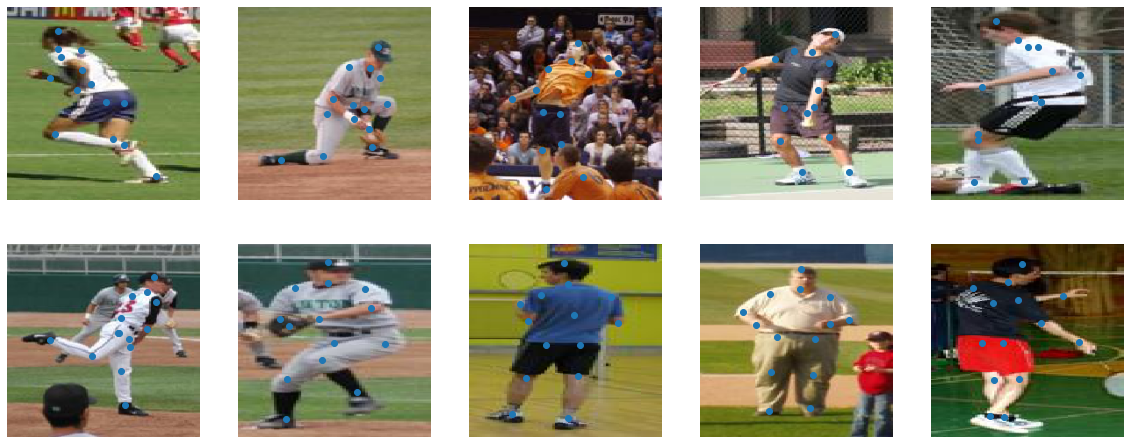

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))
for i in range(10):
  random_number = np.random.randint(2000)
  img = images[random_number]
  ax[i//5, i%5].imshow(img)
  ax[i//5, i%5].axis('off')
  ax[i//5, i%5].scatter(resized_poses[random_number][0], resized_poses[random_number][1])


In [ ]:
# Preprocessing
s = np.zeros([2000, 28]);
x = np.zeros([2000 ,220, 220, 3])
for i in range(2000):
  s[i] = np.append(resized_poses[i][0], resized_poses[i][1])
  x[i, :, :, :] = tf.keras.utils.img_to_array(images[i])

In [ ]:
# normalize
train_images_normalized = (train_images- np.mean(train_images, axis=0)) / (1e-3 + np.sqrt(np.var(train_images, axis=0)))
val_images_normalized = (val_images- np.mean(val_images, axis=0)) / (1e-3 + np.sqrt(np.var(val_images, axis=0)))
test_images_normalized = (test_images- np.mean(test_images, axis=0)) / (1e-3 + np.sqrt(np.var(test_images, axis=0)))

In [ ]:
# Select Test, Train and Validation
train_images = x[0:1400]
train_poses = s[0:1400]

val_images = x[1400:1700]
val_poses = s[1400:1700]

test_images = x[1700:2000]
test_poses = s[1700:2000]

In [ ]:
model=tf.keras.models.Sequential()
model.add(tf.keras.layers.Input(shape = (220, 220, 3)))

model.add(tf.keras.layers.Conv2D(96,11,(4,4),padding='same',activation='relu'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(256,5,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.Lambda(tf.nn.local_response_normalization))
model.add(tf.keras.layers.MaxPooling2D(2,2))

model.add(tf.keras.layers.Conv2D(384,3,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(384,3,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.Conv2D(256,3,(1,1),padding='same',activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2,2))
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(4096,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(4096,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(28,activation='linear'))

opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer = opt, loss = 'mean_squared_error', metrics='accuracy')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 lambda (Lambda)             (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 lambda_1 (Lambda)           (None, 27, 27, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 256)      0         
 2D)                                                    

In [ ]:
# Callbacks definition
def scheduler(epoch, lr):
   if epoch < 2:
     return lr
   else:
     return lr / 1.005

lr_cb = tf.keras.callbacks.LearningRateScheduler(scheduler)

class PCP(tf.keras.metrics.Metric):

  def init(self, **kwargs):
    super(PCP, self).init(**kwargs)

  def update_state(self, y_true, y_pred, sample_weight=None):
    self.confusion_matrix = tf.math.confusion_matrix(tf.math.argmax(y_true, axis=-1), tf.math.argmax(y_pred, axis=-1), number_of_classes)
    self.precision = tf.linalg.diag_part(tf.transpose(self.confusion_matrix)/tf.reshape(tf.math.reduce_sum(self.confusion_matrix, axis=0), (-1, 1)))
    self.recall = tf.linalg.diag_part(self.confusion_matrix/tf.reshape(tf.math.reduce_sum(self.confusion_matrix, axis=-1), (-1, 1)))
    self.F_score = 2*self.precision*self.precision/(self.precision+self.recall)

  def result(self):
    return tf.reduce_mean(self.F_score)

  def reset_state(self):
    self.confusion_matrix = None
    self.precision = None
    self.recall = None
    self.F_score = None

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), F_score(name='F_score')])

In [ ]:
model.fit(
    x=train_images, y=train_poses, batch_size=50, epochs=200, verbose='auto',
    callbacks=[lr_cb], validation_split=0.0, validation_data=(val_images, val_poses), shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=1, use_multiprocessing=False
)

Epoch 1/200
28/28 [==============================] - 10s 345ms/step - loss: 1627.7927 - accuracy: 0.4500 - val_loss: 1332.8954 - val_accuracy: 0.4533 - lr: 0.0091
Epoch 2/200
28/28 [==============================] - 9s 338ms/step - loss: 1654.2950 - accuracy: 0.4514 - val_loss: 1380.0079 - val_accuracy: 0.4533 - lr: 0.0091
Epoch 3/200
28/28 [==============================] - 9s 314ms/step - loss: 1605.7570 - accuracy: 0.4329 - val_loss: 1207.9382 - val_accuracy: 0.4533 - lr: 0.0091
Epoch 4/200
28/28 [==============================] - 9s 338ms/step - loss: 1558.6223 - accuracy: 0.4329 - val_loss: 1132.4415 - val_accuracy: 0.4533 - lr: 0.0091
Epoch 5/200
28/28 [==============================] - 9s 314ms/step - loss: 1612.2542 - accuracy: 0.4264 - val_loss: 1026.7507 - val_accuracy: 0.4533 - lr: 0.0090
Epoch 6/200
28/28 [==============================] - 9s 314ms/step - loss: 1612.6774 - accuracy: 0.4450 - val_loss: 1549.1682 - val_accuracy: 0.4533 - lr: 0.0090
Epoch 7/200
28/28 [========

KeyboardInterrupt: ignored

In [ ]:
@inproceedings{Johnson10,
   title = {Clustered Pose and Nonlinear Appearance Models for Human Pose Estimation},
   author = {Johnson, Sam and Everingham, Mark},
   year = {2010},
   booktitle = {Proceedings of the British Machine Vision Conference},
   note = {doi:10.5244/C.24.12}
}